In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_filepath = '../data/original/'
density_reports_filepath = data_filepath + 'DensityReports.xlsx'
historical_incidents_filepath = data_filepath + 'HistoricalIncidents.xlsx'
product_attributes_filepath = data_filepath + 'ProductAttributes.xlsx'
supplier_scorecard_filepath = data_filepath + 'SupplierScorecard.xlsx'

### Load Data

In [3]:
density_reports = pd.read_excel(density_reports_filepath)
product_attributes = pd.read_excel(product_attributes_filepath)
supplier_scorecard = pd.read_excel(supplier_scorecard_filepath)

### Prepare Data

In [4]:
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

density_reports['PackagingQuality'] = density_reports['PackagingQuality'].str.upper()
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

['Good' 'Bad' 'GOOD' 'Uncertain' 'bad']
['GOOD' 'BAD' 'UNCERTAIN']


In [5]:
unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

# Define the mappings
supplier_mappings = {
    'SupplierA': 'A',
    'supplierA': 'A',
    'SuplA': 'A',
    'SupplierB': 'B',
    'SuppB': 'B',
    'SupplierC': 'C',
    'SupllierC': 'C',
    'SupplierD': 'D',
    'SupplierE': 'E',
    'SupplierF': 'F',
    'SPLF': 'F',
    'SupplierG': 'G',
    'supplierh': 'H',
    'SupplierH': 'H'
}
# Apply the mapping to standardize SupplierName
density_reports['SupplierName'] = density_reports['SupplierName'].map(supplier_mappings).fillna(density_reports['SupplierName'])

unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

['SupplierA' 'SupplierC' 'SupplierD' 'SupplierB' 'supplierA' 'SupplierF'
 'SupplierE' 'supplierh' 'SupplierH' 'SuppB' 'SupplierG' 'SupllierC'
 'SPLF' 'SuplA']
['A' 'C' 'D' 'B' 'F' 'E' 'H' 'G']


In [6]:
report_product_attributes = pd.merge(
    density_reports[["ProductReference", "SupplierName", "GarmentType", "Material", 
                     "Weight", "ProposedUnitsPerCarton", "ProposedFoldingMethod", 
                     "ProposedLayout", "PackagingQuality", "DateOfReport"
                     ]], 
    product_attributes[['ProductReference', 'Size', 'Collection']], 
    on="ProductReference", 
    how='inner'
    )

In [7]:
report_product_attributes['Month'] = report_product_attributes['DateOfReport'].dt.to_period('M')

### Plot Data

In [8]:
color_map_base = {
    "BAD": "#d62728",          # Red
    "GOOD": "#27d65bff",      # Green
    "UNCERTAIN": "#f1ed20ff"  # Yellow
}

color_map_mod = {
    "BAD": "#d62728",          # Red, opaque
    "GOOD": "#27d65b11",      # Green, transparent
    "UNCERTAIN": "#f1ed2009"  # Yellow, transparent
}

##### Suppliers

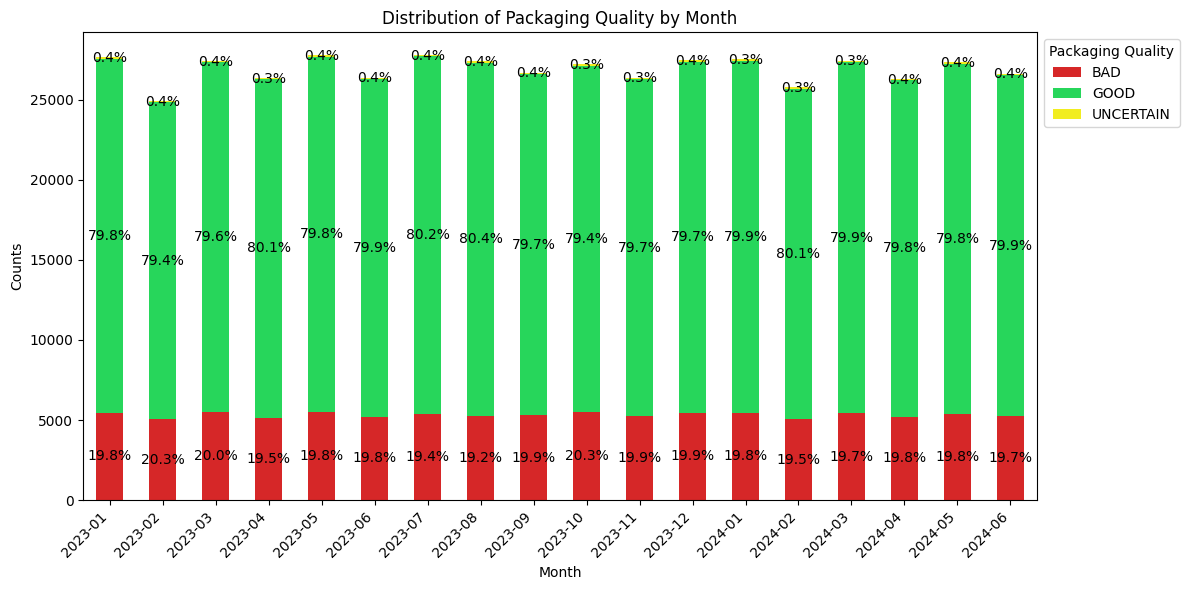

In [17]:
# Group by Month and Packaging Quality, then calculate counts
packaging_quality_by_month = report_product_attributes.groupby(['Month', 'PackagingQuality']).size().unstack(fill_value=0)

# Plot the distribution
ax = packaging_quality_by_month.plot(
    kind='bar', stacked=True, figsize=(12, 6),
    color=[color_map_base.get(col, None) for col in packaging_quality_by_month.columns]
    )
plt.title('Distribution of Packaging Quality by Month')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, month in enumerate(packaging_quality_by_month.index):
    total = packaging_quality_by_month.loc[month].sum()
    bottom = 0
    for quality in packaging_quality_by_month.columns:
        value = packaging_quality_by_month.loc[month, quality]
        percentage = (value / total) * 100
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

##### Suppliers

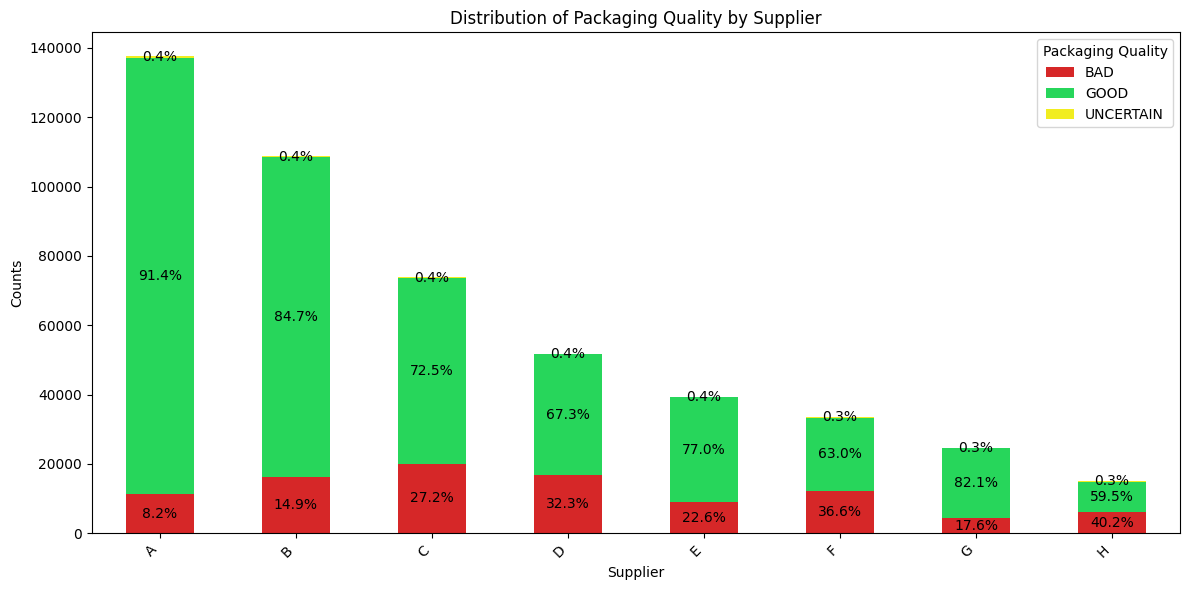

In [15]:
# Group by Supplier and Packaging Quality, then calculate counts
packaging_quality_by_supplier = report_product_attributes.groupby(['SupplierName', 'PackagingQuality']).size().unstack(fill_value=0)

# Plot the distribution
ax = packaging_quality_by_supplier.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6),
    color=[color_map_base.get(col, None) for col in packaging_quality_by_supplier.columns])
plt.title('Distribution of Packaging Quality by Supplier')
plt.xlabel('Supplier')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, supplier in enumerate(packaging_quality_by_supplier.index):
    total = packaging_quality_by_supplier.loc[supplier].sum()
    bottom = 0
    for quality in packaging_quality_by_supplier.columns:
        value = packaging_quality_by_supplier.loc[supplier, quality]
        percentage = (value / total) * 100
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

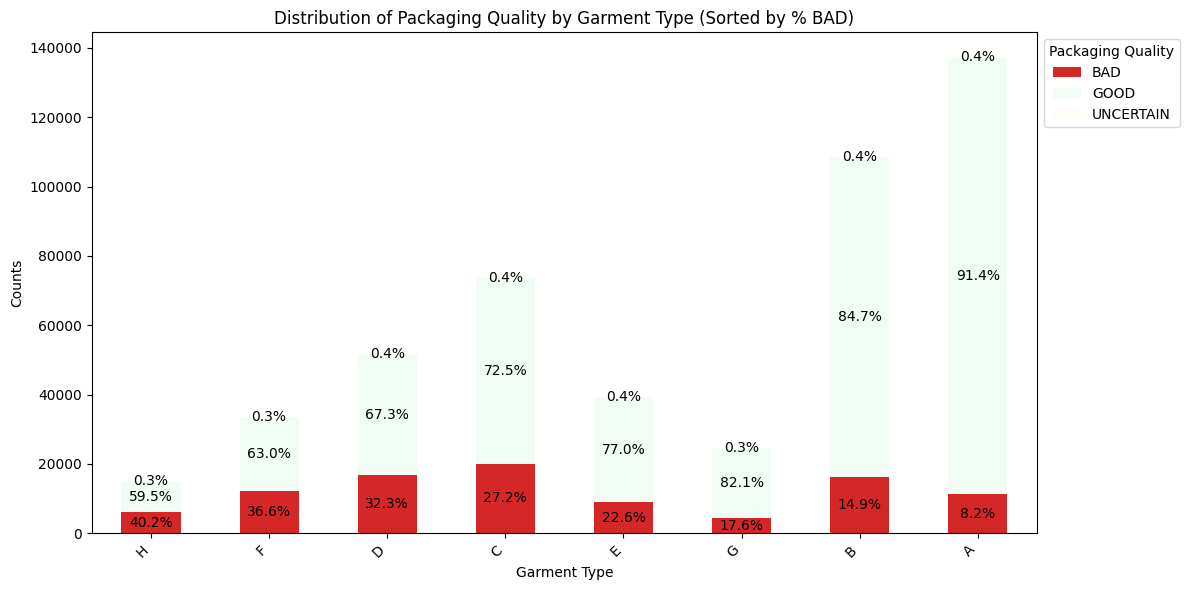

In [17]:
# Sort garment types by percentage of "BAD" in descending order
bad_percent = packaging_quality_by_supplier.apply(
    lambda row: row["BAD"] / row.sum() if row.sum() > 0 else 0, axis=1
)
sorted_by_bad_percent = packaging_quality_by_supplier.loc[bad_percent.sort_values(ascending=False).index]

# Plot the sorted distribution
ax = sorted_by_bad_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_mod.get(col, None) for col in sorted_by_bad_percent.columns]
)
plt.title('Distribution of Packaging Quality by Garment Type (Sorted by % BAD)')
plt.xlabel('Garment Type')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, garment_type in enumerate(sorted_by_bad_percent.index):
    total = sorted_by_bad_percent.loc[garment_type].sum()
    bottom = 0
    for quality in sorted_by_bad_percent.columns:
        value = sorted_by_bad_percent.loc[garment_type, quality]
        percentage = (value / total) * 100 if total > 0 else 0
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

##### Garment Types

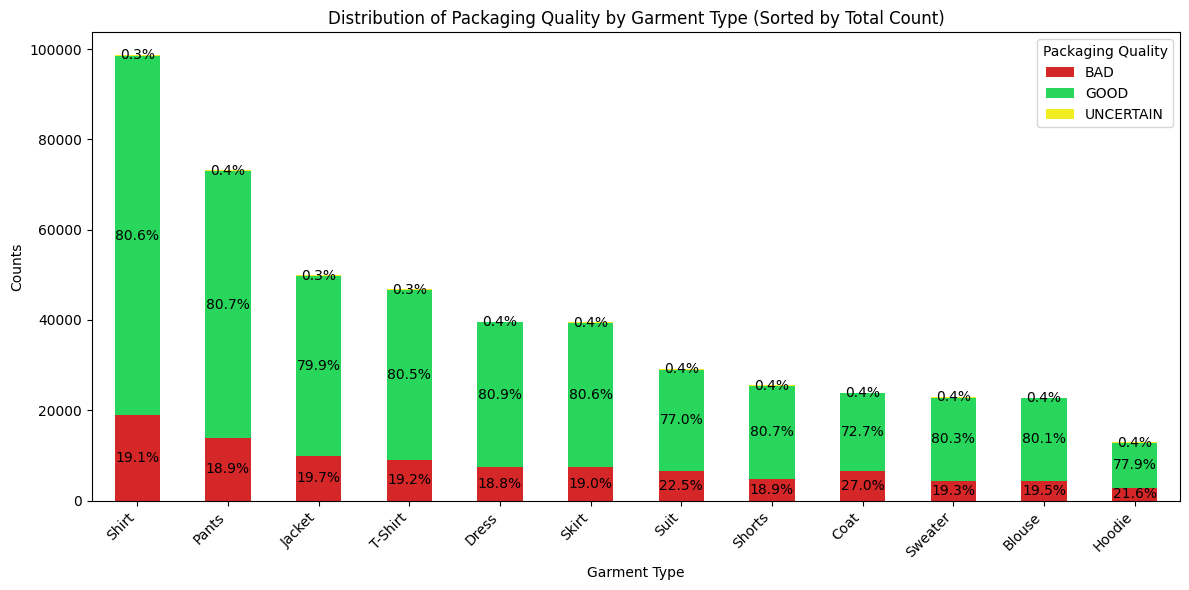

In [12]:
# Sort garment types by total count of records (sum across all packaging qualities) in descending order
packaging_quality_by_garment_type = report_product_attributes.groupby(['GarmentType', 'PackagingQuality']).size().unstack(fill_value=0)
sorted_garment_types_index = packaging_quality_by_garment_type.sum(axis=1).sort_values(ascending=False).index
sorted_packaging_quality_by_garment_type = packaging_quality_by_garment_type.loc[sorted_garment_types_index]

# Plot the sorted distribution
ax = sorted_packaging_quality_by_garment_type.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_base.get(col, None) for col in sorted_packaging_quality_by_garment_type.columns]
)
plt.title('Distribution of Packaging Quality by Garment Type (Sorted by Total Count)')
plt.xlabel('Garment Type')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, garment_type in enumerate(sorted_packaging_quality_by_garment_type.index):
    total = sorted_packaging_quality_by_garment_type.loc[garment_type].sum()
    bottom = 0
    for quality in sorted_packaging_quality_by_garment_type.columns:
        value = sorted_packaging_quality_by_garment_type.loc[garment_type, quality]
        percentage = (value / total) * 100
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

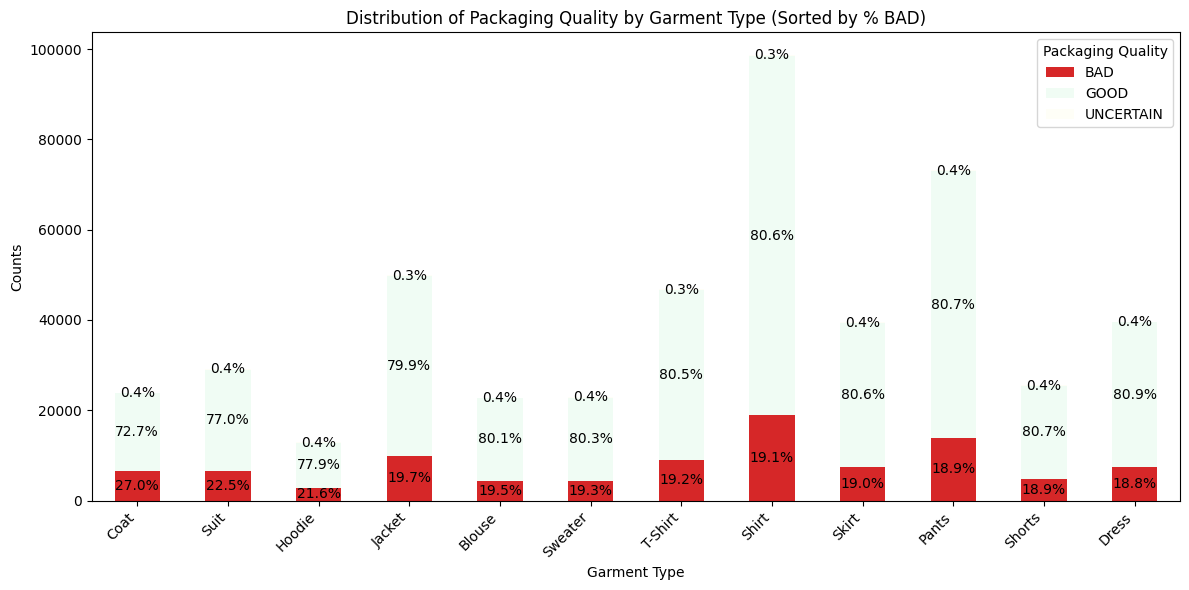

In [18]:
bad_percent = packaging_quality_by_garment_type.apply(
    lambda row: row["BAD"] / row.sum() if row.sum() > 0 else 0, axis=1
)
# Sort garment types by percentage of "BAD" in descending order
sorted_by_bad_percent = packaging_quality_by_garment_type.loc[bad_percent.sort_values(ascending=False).index]

# Plot the sorted distribution
ax = sorted_by_bad_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_mod.get(col, None) for col in sorted_by_bad_percent.columns]
)
plt.title('Distribution of Packaging Quality by Garment Type (Sorted by % BAD)')
plt.xlabel('Garment Type')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, garment_type in enumerate(sorted_by_bad_percent.index):
    total = sorted_by_bad_percent.loc[garment_type].sum()
    bottom = 0
    for quality in sorted_by_bad_percent.columns:
        value = sorted_by_bad_percent.loc[garment_type, quality]
        percentage = (value / total) * 100 if total > 0 else 0
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

##### Materials

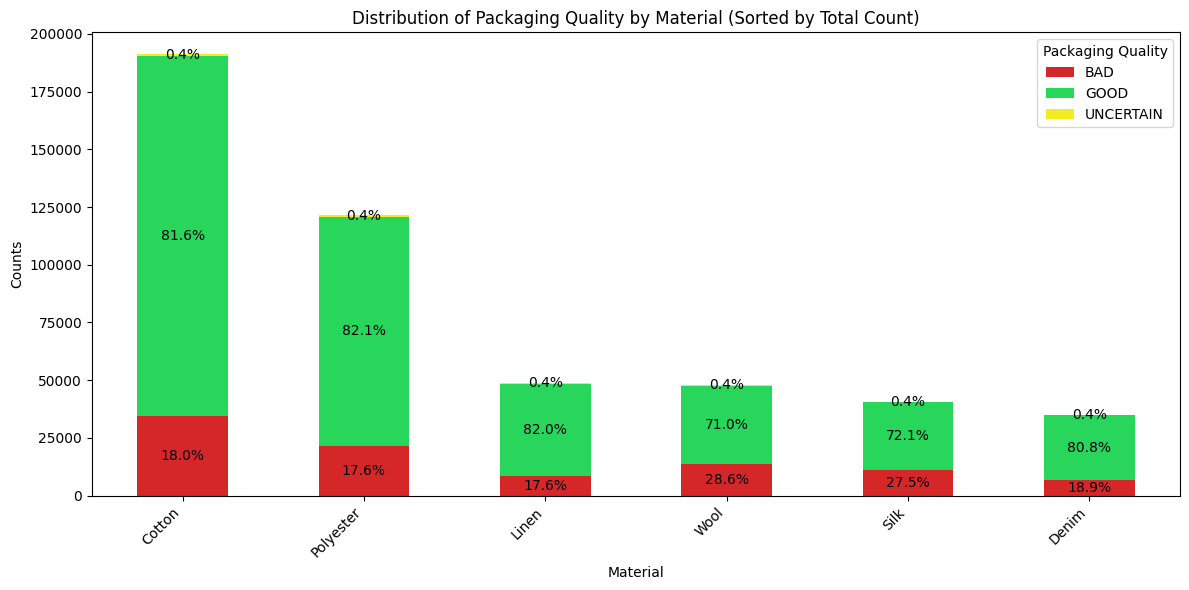

In [19]:
# Sort material by total count of records (sum across all packaging qualities) in descending order
packaging_quality_by_material = report_product_attributes.groupby(['Material', 'PackagingQuality']).size().unstack(fill_value=0)
sorted_material_index = packaging_quality_by_material.sum(axis=1).sort_values(ascending=False).index
sorted_packaging_quality_by_material = packaging_quality_by_material.loc[sorted_material_index]

# Plot the sorted distribution
ax = sorted_packaging_quality_by_material.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_base.get(col, None) for col in sorted_packaging_quality_by_material.columns]
)
plt.title('Distribution of Packaging Quality by Material (Sorted by Total Count)')
plt.xlabel('Material')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, garment_type in enumerate(sorted_packaging_quality_by_material.index):
    total = sorted_packaging_quality_by_material.loc[garment_type].sum()
    bottom = 0
    for quality in sorted_packaging_quality_by_material.columns:
        value = sorted_packaging_quality_by_material.loc[garment_type, quality]
        percentage = (value / total) * 100
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

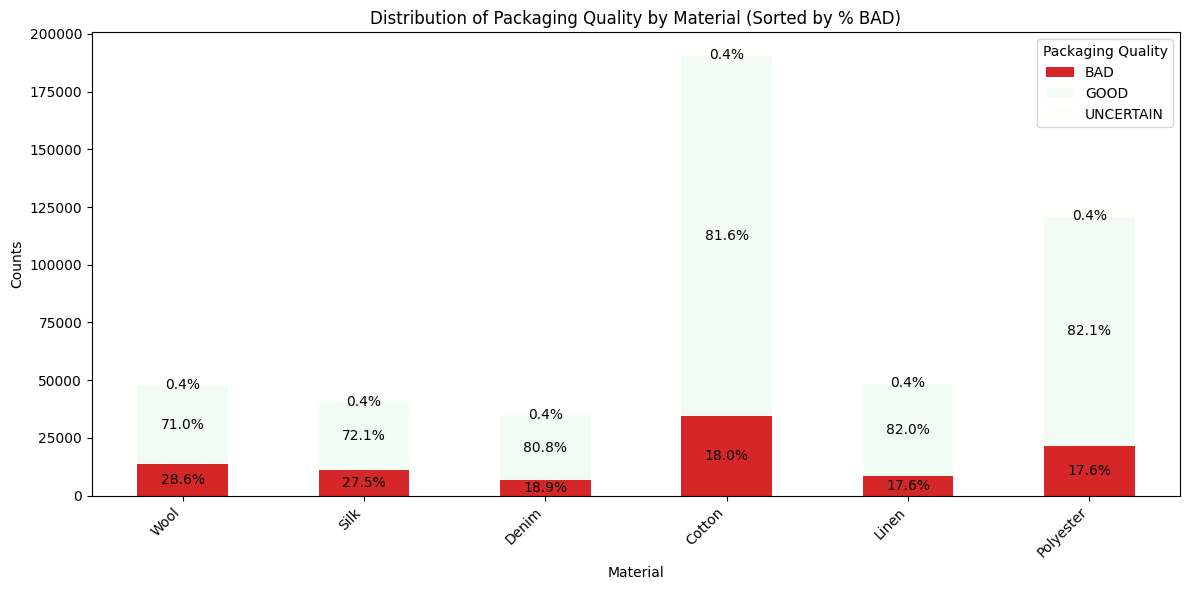

In [20]:
# Sort materials by percentage of "BAD" packaging quality records in descending order
bad_percent_material = packaging_quality_by_material.apply(
    lambda row: row["BAD"] / row.sum() if row.sum() > 0 else 0, axis=1
)
sorted_by_bad_percent_material = packaging_quality_by_material.loc[bad_percent_material.sort_values(ascending=False).index]

ax = sorted_by_bad_percent_material.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_mod.get(col, None) for col in sorted_by_bad_percent_material.columns]
)
plt.title('Distribution of Packaging Quality by Material (Sorted by % BAD)')
plt.xlabel('Material')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, material in enumerate(sorted_by_bad_percent_material.index):
    total = sorted_by_bad_percent_material.loc[material].sum()
    bottom = 0
    for quality in sorted_by_bad_percent_material.columns:
        value = sorted_by_bad_percent_material.loc[material, quality]
        percentage = (value / total) * 100 if total > 0 else 0
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

##### Size

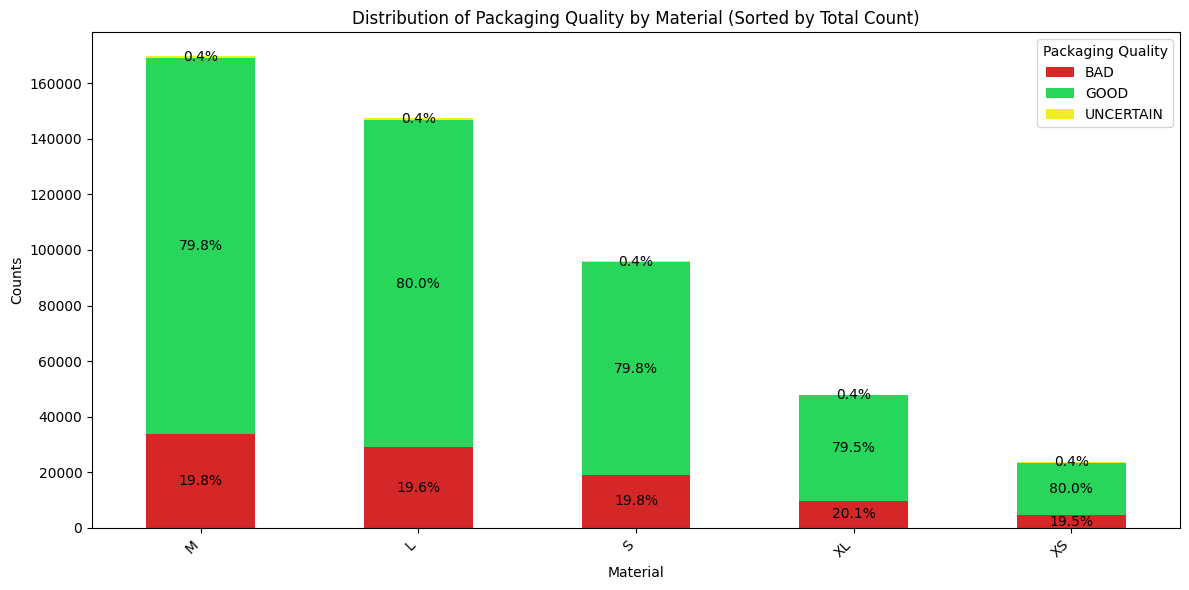

In [21]:
# Sort size by total count of records (sum across all packaging qualities) in descending order
packaging_quality_by_size = report_product_attributes.groupby(['Size', 'PackagingQuality']).size().unstack(fill_value=0)
sorted_size_index = packaging_quality_by_size.sum(axis=1).sort_values(ascending=False).index
sorted_packaging_quality_by_size = packaging_quality_by_size.loc[sorted_size_index]

# Plot the sorted distribution
ax = sorted_packaging_quality_by_size.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_base.get(col, None) for col in sorted_packaging_quality_by_size.columns]
)
plt.title('Distribution of Packaging Quality by Material (Sorted by Total Count)')
plt.xlabel('Material')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, garment_type in enumerate(sorted_packaging_quality_by_size.index):
    total = sorted_packaging_quality_by_size.loc[garment_type].sum()
    bottom = 0
    for quality in sorted_packaging_quality_by_size.columns:
        value = sorted_packaging_quality_by_size.loc[garment_type, quality]
        percentage = (value / total) * 100
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()

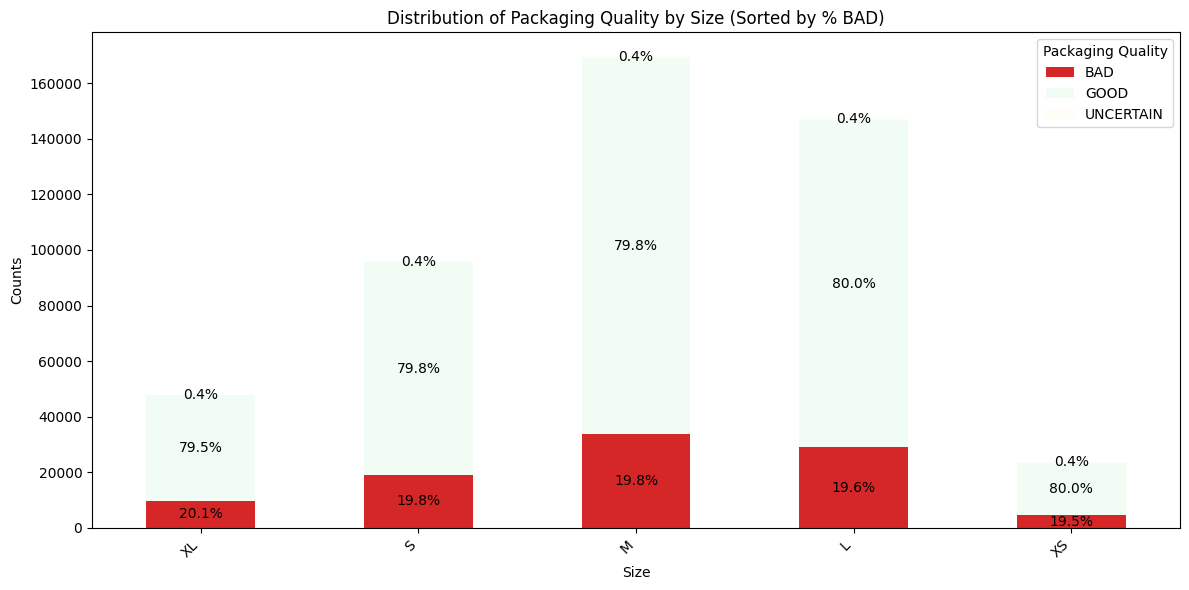

In [22]:
# Sort sizes by percentage of "BAD" packaging quality records in descending order
bad_percent_size = packaging_quality_by_size.apply(
    lambda row: row["BAD"] / row.sum() if row.sum() > 0 else 0, axis=1
)
sorted_by_bad_percent_size = packaging_quality_by_size.loc[bad_percent_size.sort_values(ascending=False).index]

ax = sorted_by_bad_percent_size.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map_mod.get(col, None) for col in sorted_by_bad_percent_size.columns]
)
plt.title('Distribution of Packaging Quality by Size (Sorted by % BAD)')
plt.xlabel('Size')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Packaging Quality', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Add percentage labels
for i, size in enumerate(sorted_by_bad_percent_size.index):
    total = sorted_by_bad_percent_size.loc[size].sum()
    bottom = 0
    for quality in sorted_by_bad_percent_size.columns:
        value = sorted_by_bad_percent_size.loc[size, quality]
        percentage = (value / total) * 100 if total > 0 else 0
        ax.text(i, bottom + value / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10)
        bottom += value

plt.show()